In [1]:
# 기본
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib import font_manager, rc
import platform
from tqdm import tqdm
import sklearn
from sklearn import linear_model
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.model_selection import train_test_split

# time
import datetime

# crawling
import requests
import lxml.html
import sqlite3
from pandas.io import sql
from bs4 import BeautifulSoup

# 한글 폰트 설정
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

In [3]:
data = pd.read_csv('outcome\\asthma_sudogwon_agg_2015SESadded.csv', encoding = 'euc-kr')
data['year'] = data['dt'].str[0:4]
data = data.loc[data['year'].isin(['2015', '2016', '2017'])].reset_index(drop = True)

In [4]:
rhinitis = pd.read_csv('outcome\\rhinitis_sudogwon_agg_2015SESadded.csv', encoding = 'euc-kr')
atopic = pd.read_csv('outcome\\atopic_sudogwon_agg_2015SESadded.csv', encoding = 'euc-kr')

In [5]:
data = pd.merge(data, rhinitis[['dt', 'air_out_idx', 'RHINITIS_em_total', 'RHINITIS_in_total', 'RHINITIS_out_total']], how = 'left', on=['dt', 'air_out_idx'])
data = pd.merge(data, atopic[['dt', 'air_out_idx', 'ATOPIC_em_total', 'ATOPIC_in_total', 'ATOPIC_out_total']], how = 'left', on=['dt', 'air_out_idx'])

In [6]:
data['so2_mean_by_idx'] = data.groupby('dt')['SO2_mean'].transform('mean')
data['co_mean_by_idx'] = data.groupby('dt')['CO_mean'].transform('mean')
# data['o3_mean_by_idx'] = data.groupby('dt')['O3_mean'].transform('mean')
data['no2_mean_by_idx'] = data.groupby('dt')['NO2_mean'].transform('mean')
data['pm10_mean_by_idx'] = data.groupby('dt')['PM10_mean'].transform('mean')

data['temp_mean_by_idx'] = data.groupby('dt')['temp_mean_total'].transform('mean')
data['humi_mean_by_idx'] = data.groupby('dt')['humi_mean_total'].transform('mean')

In [7]:
data['pm10_mean_by_idx'].max()

533.5028732175927

In [8]:
# pm10 max - 200 대체
data.loc[data['pm10_mean_by_idx'] > 500, 'pm10_mean_by_idx'] = 200

In [9]:
# in/out/em 합치기

data['asthma_in_out_em'] = data['ASTHMA_em_total'] + data['ASTHMA_in_total'] + data['ASTHMA_out_total']
data['rhinitis_in_out_em'] = data['RHINITIS_em_total'] + data['RHINITIS_in_total'] + data['RHINITIS_out_total']
data['atopic_in_out_em'] = data['ATOPIC_em_total'] + data['ATOPIC_in_total'] + data['ATOPIC_out_total']

# in/em 합치기
data['asthma_in_em'] = data['ASTHMA_em_total'] + data['ASTHMA_in_total']
data['rhinitis_in_em'] = data['RHINITIS_em_total'] + data['RHINITIS_in_total'] 
data['atopic_in_em'] = data['ATOPIC_em_total'] + data['ATOPIC_in_total'] 

In [10]:
data['asthma_in_out_em_meanbyidx'] = data.groupby('dt')['asthma_in_out_em'].transform('sum')
data['rhinitis_in_out_em_meanbyidx'] = data.groupby('dt')['rhinitis_in_out_em'].transform('sum')
data['atopic_in_out_em_meanbyidx'] = data.groupby('dt')['atopic_in_out_em'].transform('sum')

In [11]:
data[['dt', 'air_out_idx', 'asthma_in_out_em_meanbyidx', 'rhinitis_in_out_em_meanbyidx', 'atopic_in_out_em_meanbyidx']]

,dt,air_out_idx,asthma_in_out_em_meanbyidx,rhinitis_in_out_em_meanbyidx,atopic_in_out_em_meanbyidx
0,2015-01-01,1,4475.0,19081.0,594.0
1,2015-01-01,2,4475.0,19081.0,594.0
2,2015-01-01,3,4475.0,19081.0,594.0
3,2015-01-01,5,4475.0,19081.0,594.0
4,2015-01-01,6,4475.0,19081.0,594.0
...,...,...,...,...,...
78907,2017-12-31,231,7741.0,53205.0,803.0
78908,2017-12-31,233,7741.0,53205.0,803.0
78909,2017-12-31,234,7741.0,53205.0,803.0
78910,2017-12-31,237,7741.0,53205.0,803.0


In [12]:
# Aggregated model 분석을 위해, 각 outcome 변수별 date로 aggregated 된 변수 만들기. 
data['asthma_in_total_agg'] = data.groupby('dt')['ASTHMA_in_total'].transform('sum')
data['asthma_out_total_agg'] = data.groupby('dt')['ASTHMA_out_total'].transform('sum')
data['asthma_em_total_agg'] = data.groupby('dt')['ASTHMA_em_total'].transform('sum')
data['asthma_in_em_total_agg'] = data.groupby('dt')['asthma_in_em'].transform('sum')

data['rhinitis_in_total_agg'] = data.groupby('dt')['RHINITIS_in_total'].transform('sum')
data['rhinitis_out_total_agg'] = data.groupby('dt')['RHINITIS_out_total'].transform('sum')
data['rhinitis_em_total_agg'] = data.groupby('dt')['RHINITIS_em_total'].transform('sum')
data['rhinitis_in_em_total_agg'] = data.groupby('dt')['rhinitis_in_em'].transform('sum')

data['atopic_out_total_agg'] = data.groupby('dt')['ATOPIC_out_total'].transform('sum')
data['atopic_in_out_em_total_agg'] = data.groupby('dt')['atopic_in_out_em'].transform('sum')
data['atopic_in_em_total_agg'] = data.groupby('dt')['atopic_in_em'].transform('sum')

In [13]:
# drop duplicates by date

data.drop_duplicates(subset=['dt'], inplace = True)
data.reset_index(inplace = True, drop = True)

In [14]:
data[['dt', 'air_out_idx', 'asthma_in_out_em_meanbyidx', 'rhinitis_in_out_em_meanbyidx', 'atopic_in_out_em_meanbyidx']]

,dt,air_out_idx,asthma_in_out_em_meanbyidx,rhinitis_in_out_em_meanbyidx,atopic_in_out_em_meanbyidx
0,2015-01-01,1,4475.0,19081.0,594.0
1,2015-01-02,1,50704.0,269055.0,12032.0
2,2015-01-03,1,30999.0,169512.0,7976.0
3,2015-01-04,1,4820.0,23880.0,828.0
4,2015-01-05,1,50386.0,256297.0,12579.0
...,...,...,...,...,...
1091,2017-12-27,1,47580.0,326364.0,10955.0
1092,2017-12-28,1,49913.0,338363.0,11264.0
1093,2017-12-29,1,59644.0,397077.0,13513.0
1094,2017-12-30,1,44314.0,303911.0,9046.0


In [18]:
data['asthma_in_out_em_meanbyidx'].describe()

count     1096.000000
mean     31861.863139
std      15684.678378
min       1811.000000
25%      22362.750000
50%      34154.500000
75%      41514.750000
max      78339.000000
Name: asthma_in_out_em_meanbyidx, dtype: float64

In [19]:
data['rhinitis_in_out_em_meanbyidx'].describe()

count      1096.000000
mean     171491.589416
std       87115.705718
min        8476.000000
25%      115693.750000
50%      183703.000000
75%      227282.500000
max      501535.000000
Name: rhinitis_in_out_em_meanbyidx, dtype: float64

In [20]:
data['atopic_in_out_em_meanbyidx'].describe()

count     1096.000000
mean      9125.236314
std       4208.869849
min        202.000000
25%       8513.750000
50%      10054.000000
75%      11541.000000
max      19751.000000
Name: atopic_in_out_em_meanbyidx, dtype: float64

In [33]:
data.to_csv('outcome\\data_for_aggregated_model.csv', encoding = 'euc-kr', index = False)

## Time series figure (5 pollutants)       
- with regression line

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


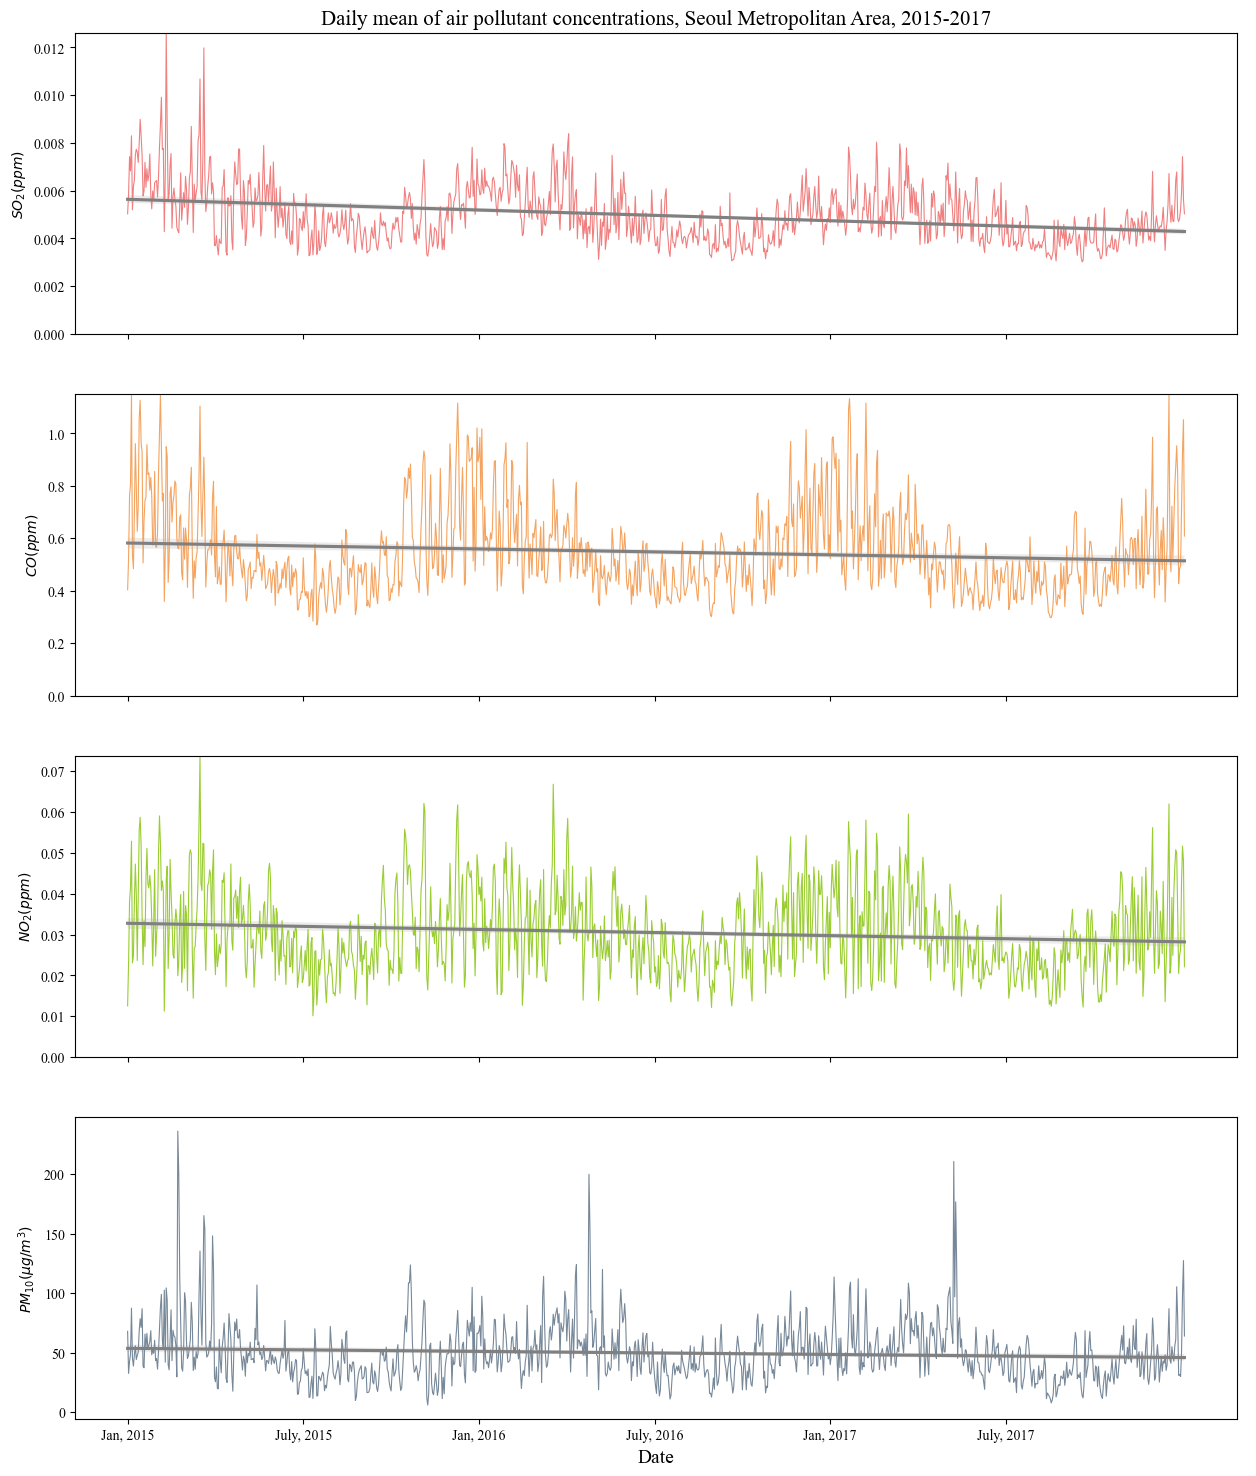

In [15]:
import matplotlib.dates as mdates
from matplotlib import ticker
plt.rcParams['font.family'] = 'Times New Roman'

# Create figure and add axes object
fig = plt.figure(figsize=(15, 18)) # figure size

# big subplot that contains all
ax = fig.add_subplot(1, 1, 1)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_xlabel('Date', fontsize = 14
)
plt.title('Daily mean of air pollutant concentrations, Seoul Metropolitan Area, 2015-2017', fontsize = 15)

ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)
# ax5 = fig.add_subplot(4, 1, 5)
# ax6 = fig.add_subplot(6, 1, 6)
# ax7 = fig.add_subplot(3, 3, 7)
# ax8 = fig.add_subplot(3, 3, 8)
# ax9 = fig.add_subplot(3, 3, 9)
# ax10 = fig.add_subplot(4, 3, 10)
# ax11 = fig.add_subplot(4, 3, 11) 
# ax12 = fig.add_subplot(4, 3, 12)
# ax13 = fig.add_subplot(5, 3, 13)
# ax14 = fig.add_subplot(5, 3, 14)
# ax15 = fig.add_subplot(5, 3, 15)

# font size
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# so2_AQI
# ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
ax1.plot(data.index, data['so2_mean_by_idx'], linewidth = 0.8, color='lightcoral')
sns.regplot(data=data, x = data.index, y = 'so2_mean_by_idx', ax = ax1, color = 'gray', label='Linear Model', scatter=False)
# ci = ax1.get_children()[2]                   # confidence band 추출
# ci.set(fc="yellow", ec="orange", alpha=0.8) # face & edge color, alpha 조정
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# ax1.set_yticks(range(len(dataset)),list(dataset['category']))
ax1.set_ylabel(r'$SO_2(ppm)$')
ax1.set_xticks(np.arange(0, 1092, 182))
ax1.set_xticklabels([])
# ax1.tick_params(bottom=False)
ax1.set_ylim([0, data['so2_mean_by_idx'].max() + 0.000001])
# ax1.set_xlim([0.8, 1.5])
# ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# co_AQI
# ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
ax2.plot(data.index, data['co_mean_by_idx'], linewidth = 0.8, color='sandybrown')
sns.regplot(data=data, x = data.index, y = 'co_mean_by_idx', ax = ax2, color = 'gray', label='Linear Model', scatter=False)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# ax1.set_yticks(range(len(dataset)),list(dataset['category']))
ax2.set_ylabel(r'$CO(ppm)$')
ax2.set_xticks(np.arange(0, 1092, 182))
ax2.set_xticklabels([])
# ax2.tick_params(bottom=False)
ax2.set_ylim([0, data['co_mean_by_idx'].max()])
# ax1.set_xlim([0.8, 1.5])
# ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# # o3_AQI
# # ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
# ax3.plot(data['dt'], data['o3_mean_by_idx'], linewidth = 0.5, color='darkkhaki')
# ax3.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# # ax1.set_yticks(range(len(dataset)),list(dataset['category']))
# ax3.set_ylabel(r'$O_3$')
# ax3.set_xticklabels([])
# # ax3.set_ylim([0, data['o3_AQI_mean_by_idx'].max() + 30, 20])
# # ax1.set_xlim([0.8, 1.5])
# # ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# # mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# # ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# no2_AQI
# ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
ax3.plot(data.index, data['no2_mean_by_idx'], linewidth = 0.8, color='yellowgreen')
sns.regplot(data=data, x = data.index, y = 'no2_mean_by_idx', ax = ax3, color = 'gray', label='Linear Model', scatter=False)
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# ax1.set_yticks(range(len(dataset)),list(dataset['category']))
ax3.set_ylabel(r'$NO_2(ppm)$')
# ax3.tick_params(bottom=False)
ax3.set_xticks(np.arange(0, 1092, 182))
ax3.set_xticklabels([])
ax3.set_ylim([0, data['no2_mean_by_idx'].max()])
# ax1.set_xlim([0.8, 1.5])
# ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# pm10_AQI
# ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
ax4.plot(data.index, data['pm10_mean_by_idx'], linewidth = 0.8, color='lightslategray')
sns.regplot(data=data, x = data.index, y = 'pm10_mean_by_idx', ax = ax4, color = 'gray', label='Linear Model', scatter=False)
# ax4.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# labels = ['Jan, 2015', 'July, 2015', 'Jan, 2016', 'July, 2016', 'Jan, 2017', 'July, 2017']
# ax4.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
# ax1.set_yticks(range(len(dataset)),list(dataset['category']))
ax4.set_ylabel(r'$PM_{10}(\mu g/m^3)$')
ax4.set_xticks(np.arange(0, 1092, 182))
ax4.set_xticklabels(['Jan, 2015', 'July, 2015', 'Jan, 2016', 'July, 2016', 'Jan, 2017', 'July, 2017'])
# ax5.set_ylim([0, data['pm10_AQI_mean_by_idx'].max() + 30])
# ax1.set_xlim([0.8, 1.5])
# ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# # pm25_AQI
# # ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
# ax6.plot(data['date'], data['pm25_AQI_mean_by_idx'], linewidth = 0.5, color='cornflowerblue')
# ax6.xaxis.set_major_locator(mdates.DayLocator(interval=366))
# # ax1.set_yticks(range(len(dataset)),list(dataset['category']))
# ax6.set_ylabel(r'$PM_2.5$' + ' ' + r'$AQI$')
# ax6.set_xticklabels([])
# ax6.set_xticklabels(['Jan, 2009', 'Jan, 2010', 'Jan, 2011', 'Jan, 2012', 'Jan, 2013', 'Jan, 2014', 'Jan, 2015', 'Jan, 2016', 'Jan, 2017', 'Jan, 2018', 'Jan, 2019'])
# # ax5.set_ylim([0, data['pm10_AQI_mean_by_idx'].max() + 30])
# # ax1.set_xlim([0.8, 1.5])
# # ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# # mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# # ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)


# plt.subplots_adjust(left=0.125,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.1, 
#                     hspace=0.15)

plt.savefig('D:\\SNUlab\\ESF_\\figures\\pollutant_visualize.png', facecolor = 'w', bbox_inches = "tight") # save
plt.savefig('D:\\SNUlab\\ESF_\\figures\\pollutant_visualize.pdf', facecolor = 'w', bbox_inches = "tight") # save, pdf
plt.savefig('D:\\SNUlab\\ESF_\\figures\\pollutant_visualize.eps', format = 'eps', facecolor = 'w', bbox_inches = "tight") # save, eps

plt.show()


## Outcome figure

In [193]:
1096/6

182.66666666666666

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


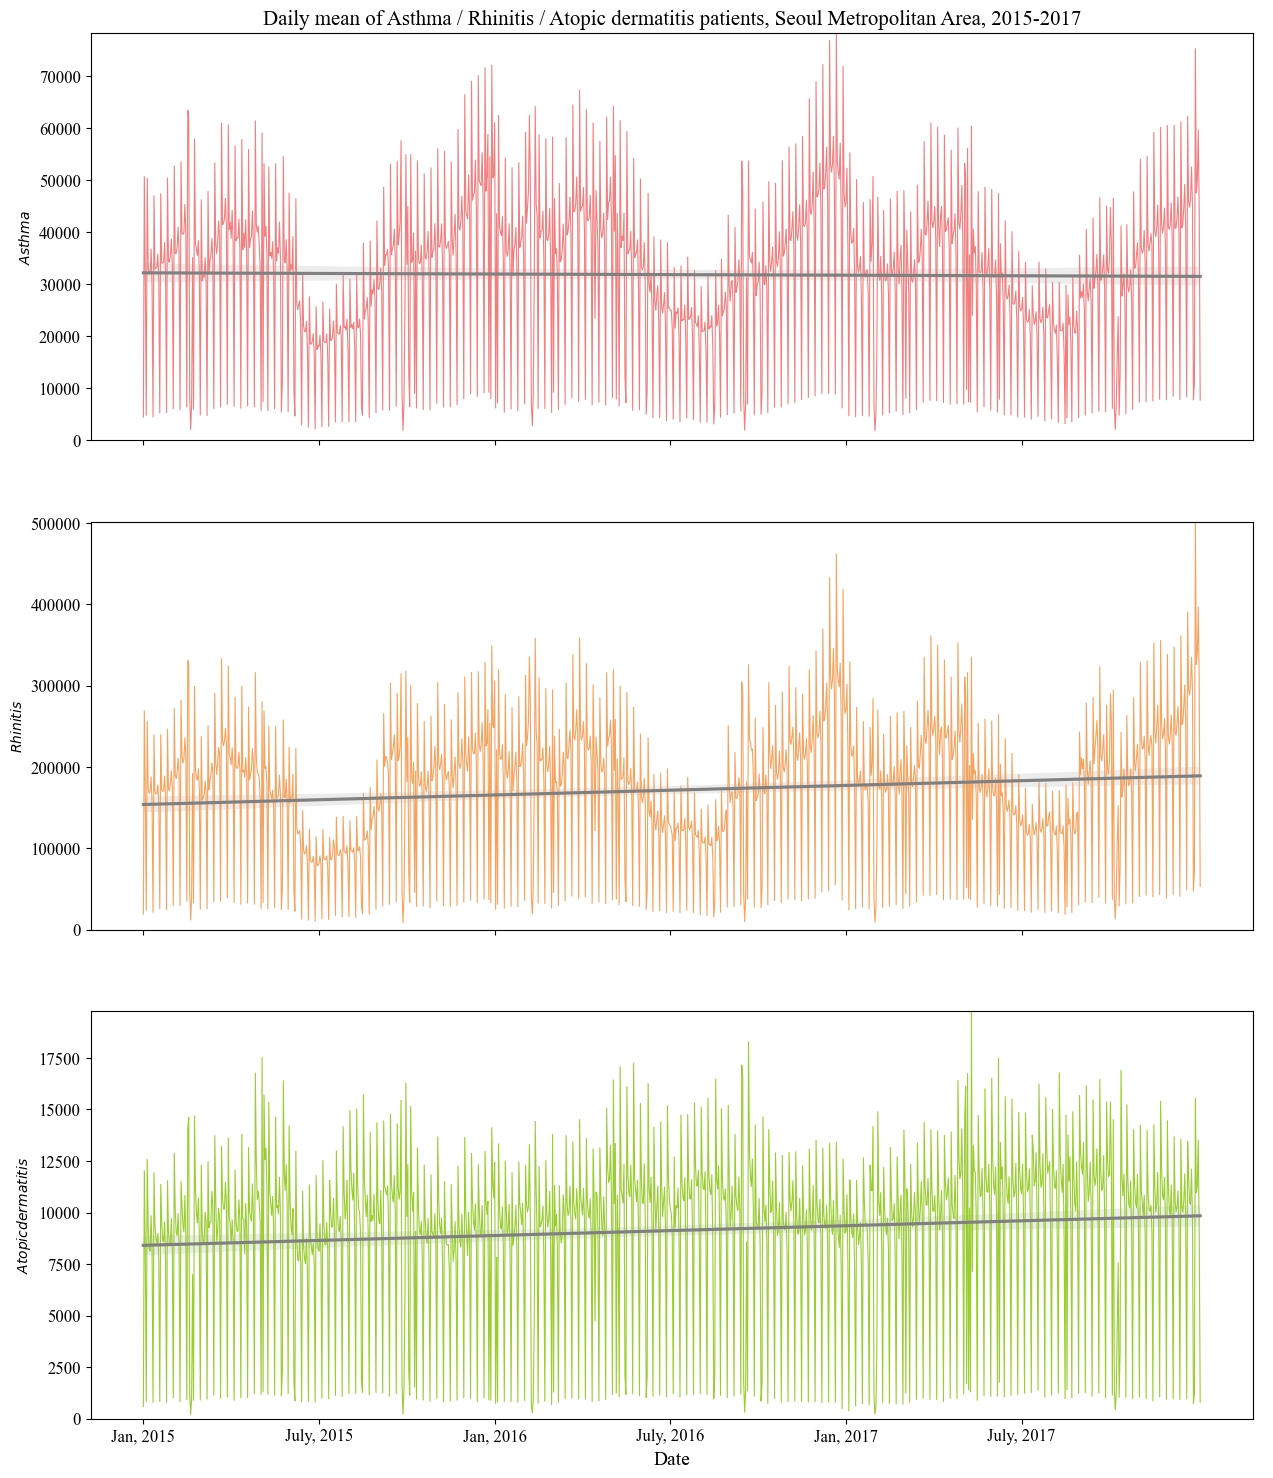

In [16]:
import matplotlib.dates as mdates
from matplotlib import ticker
plt.rcParams['font.family'] = 'Times New Roman'

# Create figure and add axes object
fig = plt.figure(figsize=(15, 18)) # figure size

# big subplot that contains all
ax = fig.add_subplot(1, 1, 1)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_xlabel('Date', fontsize = 14
)
plt.title('Daily mean of Asthma / Rhinitis / Atopic dermatitis patients, Seoul Metropolitan Area, 2015-2017', fontsize = 15)

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
# ax4 = fig.add_subplot(4, 1, 4)
# ax5 = fig.add_subplot(4, 1, 5)
# ax6 = fig.add_subplot(6, 1, 6)
# ax7 = fig.add_subplot(3, 3, 7)
# ax8 = fig.add_subplot(3, 3, 8)
# ax9 = fig.add_subplot(3, 3, 9)
# ax10 = fig.add_subplot(4, 3, 10)
# ax11 = fig.add_subplot(4, 3, 11) 
# ax12 = fig.add_subplot(4, 3, 12)
# ax13 = fig.add_subplot(5, 3, 13)
# ax14 = fig.add_subplot(5, 3, 14)
# ax15 = fig.add_subplot(5, 3, 15)

# font size
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# asthma
# ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
ax1.plot(data.index, data['asthma_in_out_em_meanbyidx'], linewidth = 0.8, color='lightcoral')
sns.regplot(data=data, x = data.index, y = 'asthma_in_out_em_meanbyidx', ax = ax1, color = 'gray', label='Linear Model', scatter=False)
# ci = ax1.get_children()[2]                   # confidence band 추출
# ci.set(fc="yellow", ec="orange", alpha=0.8) # face & edge color, alpha 조정
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# ax1.set_yticks(range(len(dataset)),list(dataset['category']))
ax1.set_ylabel(r'$Asthma$')
ax1.set_xticks(np.arange(0, 1092, 182))
ax1.set_xticklabels([])
# ax1.tick_params(bottom=False)
ax1.set_ylim([0, data['asthma_in_out_em_meanbyidx'].max() + 20])
# ax1.set_xlim([0.8, 1.5])
# ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# rhinitis
# ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
ax2.plot(data.index, data['rhinitis_in_out_em_meanbyidx'], linewidth = 0.8, color='sandybrown')
sns.regplot(data=data, x = data.index, y = 'rhinitis_in_out_em_meanbyidx', ax = ax2, color = 'gray', label='Linear Model', scatter=False)
# ax2.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# ax1.set_yticks(range(len(dataset)),list(dataset['category']))
ax2.set_ylabel(r'$Rhinitis$')
ax2.set_xticks(np.arange(0, 1092, 182))
ax2.set_xticklabels([])
# ax2.tick_params(bottom=False)
ax2.set_ylim([0, data['rhinitis_in_out_em_meanbyidx'].max() + 40])
# ax1.set_xlim([0.8, 1.5])
# ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# # o3_AQI
# # ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
# ax3.plot(data['dt'], data['o3_mean_by_idx'], linewidth = 0.5, color='darkkhaki')
# ax3.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# # ax1.set_yticks(range(len(dataset)),list(dataset['category']))
# ax3.set_ylabel(r'$O_3$')
# ax3.set_xticklabels([])
# # ax3.set_ylim([0, data['o3_AQI_mean_by_idx'].max() + 30, 20])
# # ax1.set_xlim([0.8, 1.5])
# # ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# # mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# # ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# atopic
# ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
ax3.plot(data.index, data['atopic_in_out_em_meanbyidx'], linewidth = 0.8, color='yellowgreen')
sns.regplot(data=data, x = data.index, y = 'atopic_in_out_em_meanbyidx', ax = ax3, color = 'gray', label='Linear Model', scatter=False)
# ax3.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# ax1.set_yticks(range(len(dataset)),list(dataset['category']))
ax3.set_ylabel(r'$Atopic dermatitis$')
# ax3.tick_params(bottom=False)
ax3.set_xticks(np.arange(0, 1092, 182))
ax3.set_ylim([0, data['atopic_in_out_em_meanbyidx'].max() + 20])
ax3.set_xticklabels(['Jan, 2015', 'July, 2015', 'Jan, 2016', 'July, 2016', 'Jan, 2017', 'July, 2017'])
# ax1.set_xlim([0.8, 1.5])
# ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# pm10_AQI
# ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
# ax4.plot(data.index, data['pm10_mean_by_idx'], linewidth = 0.8, color='lightslategray')
# sns.regplot(data=data, x = data.index, y = 'pm10_mean_by_idx', ax = ax4, color = 'gray', label='Linear Model', scatter=False)
# ax4.xaxis.set_major_locator(mdates.DayLocator(interval=180))
# labels = ['Jan, 2015', 'July, 2015', 'Jan, 2016', 'July, 2016', 'Jan, 2017', 'July, 2017']
# ax4.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
# ax1.set_yticks(range(len(dataset)),list(dataset['category']))
# ax4.set_ylabel(r'$PM_10$')
# ax4.set_xticks(np.arange(0, 78911, 13152))
# ax4.set_xticklabels(['Jan, 2015', 'July, 2015', 'Jan, 2016', 'July, 2016', 'Jan, 2017', 'July, 2017'])
# ax5.set_ylim([0, data['pm10_AQI_mean_by_idx'].max() + 30])
# ax1.set_xlim([0.8, 1.5])
# ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)

# # pm25_AQI
# # ax1.set_title('Multivariate (without IV)', loc='left', fontweight = 'bold')
# ax6.plot(data['date'], data['pm25_AQI_mean_by_idx'], linewidth = 0.5, color='cornflowerblue')
# ax6.xaxis.set_major_locator(mdates.DayLocator(interval=366))
# # ax1.set_yticks(range(len(dataset)),list(dataset['category']))
# ax6.set_ylabel(r'$PM_2.5$' + ' ' + r'$AQI$')
# ax6.set_xticklabels([])
# ax6.set_xticklabels(['Jan, 2009', 'Jan, 2010', 'Jan, 2011', 'Jan, 2012', 'Jan, 2013', 'Jan, 2014', 'Jan, 2015', 'Jan, 2016', 'Jan, 2017', 'Jan, 2018', 'Jan, 2019'])
# # ax5.set_ylim([0, data['pm10_AQI_mean_by_idx'].max() + 30])
# # ax1.set_xlim([0.8, 1.5])
# # ax1.vlines(1, ymin=0, ymax=6, linestyles='dashed',color='gray')
# # mybox={'facecolor':'white','edgecolor':'gray','boxstyle':'round','alpha':0.5}
# # ax1.text(3950, 28, r'$SO_2$' + ' AQI', verticalalignment='top', horizontalalignment='right', fontsize = 12, bbox=mybox)


# plt.subplots_adjust(left=0.125,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.1, 
#                     hspace=0.15)

plt.savefig('D:\\SNUlab\\ESF_\\figures\\outcome_visualize.png', facecolor = 'w', bbox_inches = "tight") # save 
plt.savefig('D:\\SNUlab\\ESF_\\figures\\outcome_visualize.pdf', facecolor = 'w', bbox_inches = "tight") # save, pdf
plt.savefig('D:\\SNUlab\\ESF_\\figures\\outcome_visualize.eps', format = 'eps', facecolor = 'w', bbox_inches = "tight") # save, eps

plt.show()



### Convert png to pdf

In [2]:
from PIL import Image

image1 = Image.open('D:\\SNUlab\\1. Results\\ESF_ (2022.08~)\\ASTHMA_em_total\\0. aggregated model\\CO_mean.png')
im1 = image1.convert('RGB')
im1.save('C://Users//admin//Dropbox//# ESF paper//ESF_followup//Submission (final version)//1. Lancet Planetary Health//Appendix - figures//test.pdf')

In [4]:
!pip install pdf2image
!apt-get install poppler-utils

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [3]:
from pdf2image import convert_from_path

file_name = "Supplementary figure 4. rhinitisOUT_NO2_overall.pdf"

page = convert_from_path("D://SNUlab//99. 기타//2024 HealthInf 출장 준비//Supplementary figure 4. rhinitisOUT_NO2_overall.pdf")
page.save("D://SNUlab//99. 기타//2024 HealthInf 출장 준비//"+"Supplementary figure 4. rhinitisOUT_NO2_overall"+".jpg", "JPEG")

PDFInfoNotInstalledError: Unable to get page count. Is poppler installed and in PATH?